In [3]:
import os
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from pydantic import BaseModel, Field
from pymoo.indicators import spacing
from tqdm.notebook import tqdm

In [4]:
filename = "results_temp.json"


class OneExperimentResults(BaseModel):
    problemName: str = Field(description="Name of the problem")
    method: str = Field(description="Name of the method")
    runID: int = Field(description="Run number")
    hv: list[float] = Field(description="Hypervolume (Normalized) of the found solutions at each iteration")
    IDG: list[float] = Field("IGD of the found solutions at each iteration")
    RSE: list[float | None] = Field("ln(RSE) of the found solutions at each iteration")
    spacing: list[float | None] = Field("Spacing indicator value of the found solutions at each iteration")
    CumBadRefs: list[float] = Field(description="Cumulative fraction of bad reference points found at each iteration")
    success: list[bool] = Field(description="Whether the method evaluated a valid reference point at each iteration")
    runtime: float = Field(description="Runtime of the experiment")


class ExperimentResults(BaseModel):
    results: list[OneExperimentResults] = Field(description="Results of the experiment")


with open(filename, "r") as f:
    data = f.read()

results = ExperimentResults.model_validate_json(data)

In [21]:
# 3 Objective forest results

problem = "dtlz7"
f_results = [r for r in results.results if r.problemName == problem]
methods = list(set([r.method for r in f_results]))
runIDs = list(set([r.runID for r in f_results]))

f_pd = pd.DataFrame(
    columns=[
        "method",
        "runID",
        "iteration",
        "HV",
        "IGD",
        "spacing",
        "RSE" "Bad Reference Points Found",
        "success",
        "runtime",
    ]
)

for r in f_results:
    # print lenghts
    to_add = pd.DataFrame(
        {
            "method": [r.method] * len(r.CumBadRefs),
            "runID": [r.runID] * len(r.CumBadRefs),
            "iteration": range(len(r.CumBadRefs)),
            "HV": r.hv + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
            "IGD": r.IDG + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
            "spacing": r.spacing + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
            "RSE": r.RSE + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
            "Bad Reference Points Found": r.CumBadRefs,
            "success": np.array(r.success).astype(int),
            "runtime": [r.runtime] * len(r.CumBadRefs),
        }
    )
    f_pd = pd.concat([f_pd, to_add])

Text(0.5, 1.0, 'RSE indicator for dtlz7')

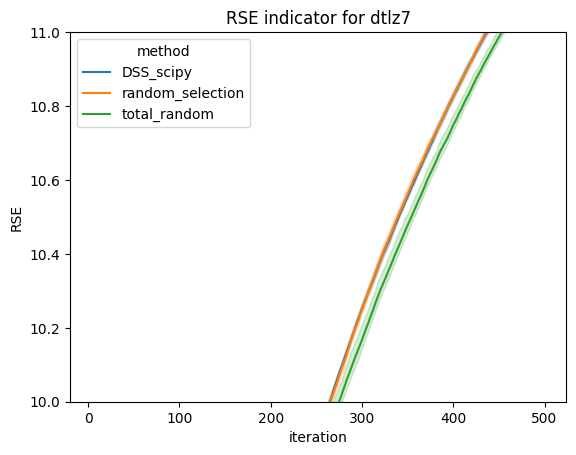

In [23]:
f, ax = plt.subplots()
ax.set()
f_pd_clean = f_pd[["RSE", "iteration", "method"]].dropna()
sns.lineplot(data=f_pd_clean.sort_values("method"), y="RSE", x="iteration", hue="method")

# Set y-axis limits
ax.set_ylim(10, 11)
ax.set_title(f"RSE indicator for {problem}")

# For problems where all RPs are eliminated, try recalculating the
# bad RPs with lower threshold values.

(0.01311139437318381, 0.1)

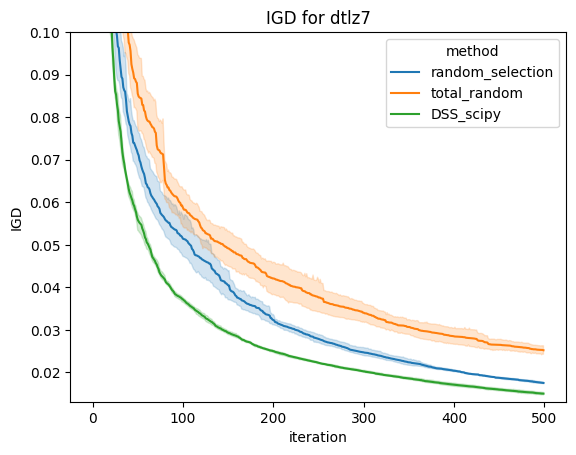

In [9]:
f, ax = plt.subplots()
# ax.set(yscale="log", xscale="log")

f_pd = f_pd[["IGD", "iteration", "method"]].dropna()
sns.lineplot(data=f_pd, x="iteration", y="IGD", hue="method")
ax.set_title(f"IGD for {problem}")
ax.set_ylim(0.9 * f_pd["IGD"].min(), 0.1)

# f.savefig(f"igd_{problem}.png")

In [17]:
def auto_plot(inputs):
    filename, problem, indicator = inputs

    class OneExperimentResults(BaseModel):
        problemName: str = Field(description="Name of the problem")
        method: str = Field(description="Name of the method")
        runID: int = Field(description="Run number")
        hv: list[float] = Field(description="Hypervolume (Normalized) of the found solutions at each iteration")
        IDG: list[float] = Field("IGD of the found solutions at each iteration")
        spacing: list[float | None] = Field("Spacing indicator value of the found solutions at each iteration")
        RSE: list[float | None] = Field("ln(RSE) of the found solutions at each iteration")
        CumBadRefs: list[float] = Field(
            description="Cumulative fraction of bad reference points found at each iteration"
        )
        success: list[bool] = Field(
            description="Whether the method evaluated a valid reference point at each iteration"
        )
        runtime: float = Field(description="Runtime of the experiment")

    class ExperimentResults(BaseModel):
        results: list[OneExperimentResults] = Field(description="Results of the experiment")

    with open(filename, "r") as f:
        data = f.read()

    results = ExperimentResults.model_validate_json(data)

    f_results = [r for r in results.results if r.problemName == problem]
    methods = list(set([r.method for r in f_results]))
    runIDs = list(set([r.runID for r in f_results]))

    f_pd = pd.DataFrame(
        columns=[
            "method",
            "runID",
            "iteration",
            "HV",
            "IGD",
            "spacing" "Bad Reference Points Found",
            "success",
            "runtime",
        ]
    )

    for r in f_results:
        # print lenghts
        to_add = pd.DataFrame(
            {
                "method": [r.method] * len(r.CumBadRefs),
                "runID": [r.runID] * len(r.CumBadRefs),
                "iteration": range(len(r.CumBadRefs)),
                "HV": r.hv + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
                "IGD": r.IDG + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
                "spacing": r.spacing + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
                "RSE": r.RSE + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
                "Bad Reference Points Found": r.CumBadRefs,
                "success": np.array(r.success).astype(int),
                "runtime": [r.runtime] * len(r.CumBadRefs),
            }
        )
        f_pd = pd.concat([f_pd, to_add])

    f, ax = plt.subplots()
    ax.set()
    f_pd_clean = f_pd[[indicator, "iteration", "method"]].dropna()
    sns.lineplot(data=f_pd_clean.sort_values("method"), y=indicator, x="iteration", hue="method")

    # Set y-axis limits
    if indicator == "IGD" or indicator == "spacing":
        ax.set_ylim(0.9 * f_pd[indicator].min(), 0.1)
    elif indicator == "HV":
        ax.set_ylim(f_pd_clean[indicator][f_pd_clean["iteration"] < 50].max(), 1)
    elif indicator == "RSE":
        ax.set_ylim(f_pd_clean[indicator][f_pd_clean["iteration"] < 50].min(), 0.9 * f_pd_clean[indicator].min())
    ax.set_title(f"{indicator} indicator for {problem}")
    f.savefig(f"figures/{indicator}_{problem}.png")

In [6]:
problems = [
    "dtlz5_5",
    "dtlz5_3",
    "dtlz7",
    "dtlz5_4",
    "forest_3",
    "forest_4",
    "VCW",
    "DBD",
]

indicators = ["spacing", "HV", "IGD"]
filename = "results_temp.json"

all_figs_opts = []
for problem in problems:
    for indicator in indicators:
        all_figs_opts.append((filename, problem, indicator))

In [28]:
results = []
with Pool(len(os.sched_getaffinity(0))) as p:
    max_exp = len(all_figs_opts)
    with tqdm(total=max_exp) as pbar:
        for i, result in enumerate(p.imap_unordered(auto_plot, all_figs_opts)):
            pbar.update()

  0%|          | 0/24 [00:00<?, ?it/s]

In [30]:
with open(filename, "r") as f:
    data = f.read()

results = ExperimentResults.model_validate_json(data)

In [24]:
methods = ["DSS_scipy", "random_selection", "total_random"]
RSE_results = pd.DataFrame(columns=["method","problem", "RSE"])

for result in results.results:
    method = result.method
    problem = result.problemName
    RSE = result.RSE[-1]
    RSE_results = pd.concat([RSE_results, pd.DataFrame({"method": method, "problem": problem, "RSE": RSE}, index=[0])])

<Axes: xlabel='problem', ylabel='RSE'>

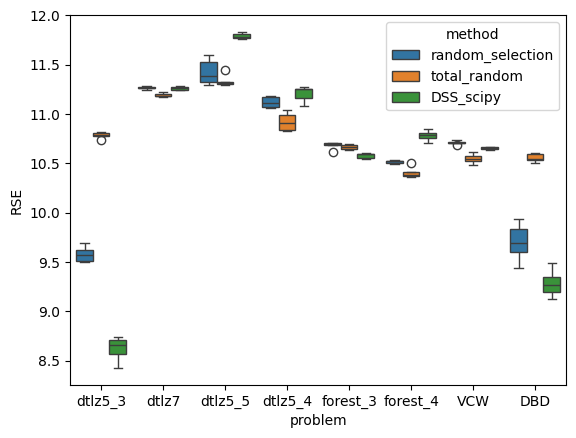

In [25]:
sns.boxplot(data=RSE_results, x="problem", y="RSE", hue="method")

In [30]:
RSE_results.groupby(["problem"], group_keys=True)["RSE"].apply(lambda x: x-x.min()).reset_index()

,problem,level_1,RSE
0,DBD,0,0.812278
1,DBD,0,0.702254
2,DBD,0,0.563676
3,DBD,0,0.309826
4,DBD,0,0.474329
...,...,...,...
115,forest_4,0,0.492310
116,forest_4,0,0.351344
117,forest_4,0,0.397440
118,forest_4,0,0.430423


<Axes: xlabel='iteration', ylabel='1-HV'>

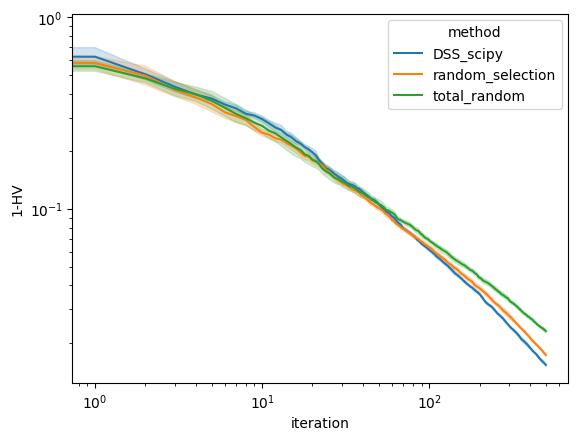

In [30]:
f, ax = plt.subplots()
ax.set(xscale="log", yscale="log")
f_pd["1-HV"] = 1 - f_pd["HV"]
sns.lineplot(data=f_pd, x="iteration", y="1-HV", hue="method")

# f.savefig(f"hv_{problem}.png")

In [5]:
rolling = pd.DataFrame(columns=["method", "runID", "iteration", "success"])

In [6]:
ids = f_pd["runID"].unique()
methods = f_pd["method"].unique()

for method in methods:
    for runID in ids:
        r = f_pd[(f_pd["method"] == method) & (f_pd["runID"] == runID)]
        rolling = pd.concat(
            [
                rolling,
                pd.DataFrame(
                    {
                        "method": [method] * len(r),
                        "runID": [runID] * len(r),
                        "iteration": r["iteration"],
                        "success": r["success"].cumsum(),
                    }
                ),
            ]
        )
rolling = rolling.dropna()

<Axes: xlabel='iteration', ylabel='success'>

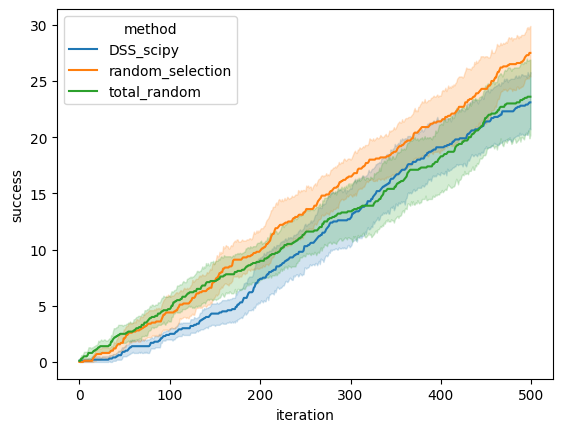

In [7]:
f, ax = plt.subplots()
sns.lineplot(data=rolling, x="iteration", y="Cumulative success", hue="method")
# f.savefig(f"success_{problem}.png")

<Axes: xlabel='iteration', ylabel='Bad Reference Points Found'>

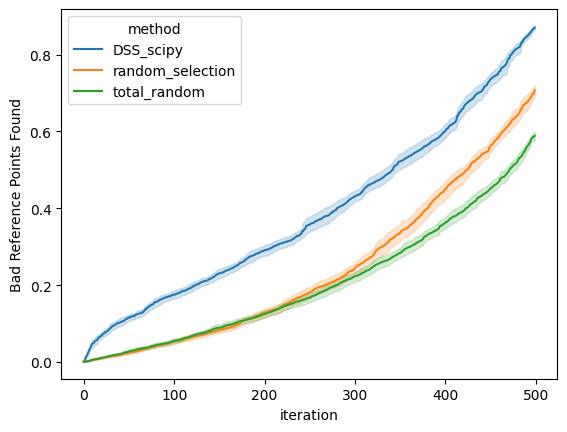

In [34]:
f, ax = plt.subplots()
sns.lineplot(data=f_pd, x="iteration", y="Bad Reference Points Found", hue="method")
# f.savefig(f"bad_ref_found_{problem}.png")